# Imports

In [65]:
import ee
import numpy as np
import math
import geemap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [66]:
#ee.Authenticate()


In [67]:

# Initialize Google Earth Engine
ee.Initialize()

In [68]:
nm_path = r"C:\Users\bsf31\Documents\data\NM\nm_vector.gpkg"
study_boundary = gpd.read_file(nm_path, layer='counties_dissolved')
lordsburg_gdf = gpd.read_file(nm_path, layer='lordsburg')

In [69]:
lordsburg_gdf = lordsburg_gdf.to_crs(epsg=4326)


In [70]:
lordsburg_gdf

,id,name,area,geometry
0,0,Lordsburg,4.747221e+06,"MULTIPOLYGON (((-108.72152 32.33398, -108.7215..."


In [71]:
# Convert to Earth Engine geometry
ee_boundary = geemap.geopandas_to_ee(study_boundary)

ee_lordsburg = geemap.geopandas_to_ee(lordsburg_gdf).geometry()


In [72]:
ee_boundary_coordinates = ee_boundary.geometry()

In [73]:

# Create a geemap interactive map
Map = geemap.Map()

Map.addLayer(ee_lordsburg, {}, "Lordsburg Geometry")

Map.centerObject(ee_lordsburg, zoom=10)


Map

Map(center=[32.34598300192576, -108.70956949640477], controls=(WidgetControl(options=['position', 'transparent…

# Landsat Collection 2

In [74]:
# Function to scale the surface temperature band and convert to Fahrenheit
def scale_lst(image):
    lst_k = image.select('ST_B10').multiply(0.00341802).add(149.0)
    lst_f = lst_k.subtract(273.15).multiply(1.8).add(32)
    return image.addBands(lst_f.rename('LST_F'))

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4'])
    return image.addBands(ndvi.rename('NDVI'))

# Function to calculate Fraction of Vegetation Cover
def calculate_fvc(image):
    fvc = image.select('NDVI').subtract(0.2).divide(0.3).pow(2).clamp(0, 1)
    return image.addBands(fvc.rename('FVC'))

# Function to calculate Emissivity
def calculate_emissivity(image):
    emissivity = image.select('FVC').multiply(0.0004).add(0.986)
    return image.addBands(emissivity.rename('Emissivity'))

# Define a function to clip each image to the ROI
def clip_to_region(image,roi):
    return image.clip(roi)


In [75]:
pt = ee.Geometry.Point([-108.71, 32.35])  
landsat_collection1 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate('2019-04-01', '2024-11-01') \
    .filter(ee.Filter.calendarRange(5, 9, 'month')) \
    .filterBounds(pt)\
    .filter(ee.Filter.lt('CLOUD_COVER', 6))  # Filter for images with less than 10% cloud cover

In [76]:
""" pt = ee.Geometry.Point([-108.71, 32.35])  

# Load the Landsat 8 collection and filter images based on criteria
landsat_collection1 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate('2019-04-01', '2019-09-18') \
    .filter(ee.Filter.calendarRange(5, 9, 'month')) \
    .filterBounds(pt)\
    .filter(ee.Filter.lt('CLOUD_COVER', 9))  # Filter for images with less than 10% cloud cover
# Load the Landsat 8 collection and filter images based on criteria
landsat_collection2 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate('2019-09-19', '2024-08-14') \
    .filter(ee.Filter.calendarRange(5, 9, 'month')) \
    .filterBounds(pt)\
    .filter(ee.Filter.lt('CLOUD_COVER', 9))  # Filter for images with less than 10% cloud cover

# Load the Landsat 8 collection and filter images based on criteria
landsat_collection3 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate( '2024-08-15', '2024-11-01') \
    .filter(ee.Filter.calendarRange(5, 9, 'month')) \
    .filterBounds(pt)\
    .filter(ee.Filter.lt('CLOUD_COVER', 9))  # Filter for images with less than 10% cloud cover
 """

' pt = ee.Geometry.Point([-108.71, 32.35])  \n\n# Load the Landsat 8 collection and filter images based on criteria\nlandsat_collection1 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")     .filterDate(\'2019-04-01\', \'2019-09-18\')     .filter(ee.Filter.calendarRange(5, 9, \'month\'))     .filterBounds(pt)    .filter(ee.Filter.lt(\'CLOUD_COVER\', 9))  # Filter for images with less than 10% cloud cover\n# Load the Landsat 8 collection and filter images based on criteria\nlandsat_collection2 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")     .filterDate(\'2019-09-19\', \'2024-08-14\')     .filter(ee.Filter.calendarRange(5, 9, \'month\'))     .filterBounds(pt)    .filter(ee.Filter.lt(\'CLOUD_COVER\', 9))  # Filter for images with less than 10% cloud cover\n\n# Load the Landsat 8 collection and filter images based on criteria\nlandsat_collection3 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")     .filterDate( \'2024-08-15\', \'2024-11-01\')     .filter(ee.Filter.calendarRange(5, 9, \'month

In [77]:
""" # Combine the collections
combined_collection = landsat_collection1.merge(landsat_collection2).merge(landsat_collection3)
# Get the list of image dates that meet the criteria
image_dates = combined_collection.aggregate_array('system:time_start').map(lambda t: ee.Date(t).format('YYYY-MM-dd')).getInfo()

print("Selected Image Dates:")
print(image_dates)
# Apply all processing steps
processed_collection = combined_collection \
    .map(lambda image: image.clip(ee_lordsburg)) \
    .map(scale_lst) \
    .map(calculate_ndvi) \
    .map(calculate_fvc) \
    .map(calculate_emissivity) 
 """


' # Combine the collections\ncombined_collection = landsat_collection1.merge(landsat_collection2).merge(landsat_collection3)\n# Get the list of image dates that meet the criteria\nimage_dates = combined_collection.aggregate_array(\'system:time_start\').map(lambda t: ee.Date(t).format(\'YYYY-MM-dd\')).getInfo()\n\nprint("Selected Image Dates:")\nprint(image_dates)\n# Apply all processing steps\nprocessed_collection = combined_collection     .map(lambda image: image.clip(ee_lordsburg))     .map(scale_lst)     .map(calculate_ndvi)     .map(calculate_fvc)     .map(calculate_emissivity) \n '

In [78]:
# Get the list of image dates that meet the criteria
image_dates = landsat_collection1.aggregate_array('system:time_start').map(lambda t: ee.Date(t).format('YYYY-MM-dd')).getInfo()

print("Selected Image Dates:")
print(image_dates)


Selected Image Dates:
['2019-05-29', '2019-06-30', '2019-07-16', '2019-08-01', '2019-09-02', '2019-09-18', '2020-05-15', '2020-05-31', '2020-06-16', '2020-08-03', '2020-08-19', '2020-09-04', '2020-09-20', '2021-06-19', '2021-08-06', '2021-08-22', '2021-09-07', '2022-05-05', '2022-05-21', '2022-06-06', '2022-07-08', '2022-07-24', '2022-09-10', '2023-05-08', '2023-05-24', '2023-06-25', '2023-07-27', '2023-08-12', '2023-09-29', '2024-05-26', '2024-06-11', '2024-07-13', '2024-07-29', '2024-08-14', '2024-08-30', '2024-09-15', '2019-05-04', '2019-06-21', '2019-08-24', '2020-05-06', '2020-05-22', '2020-06-07', '2020-06-23', '2020-09-27', '2021-05-09', '2021-05-25', '2021-07-12', '2021-08-29', '2021-09-14', '2022-05-12', '2022-06-13', '2022-08-16', '2022-09-17', '2023-05-31', '2023-06-16', '2023-09-04', '2024-05-01', '2024-05-17', '2024-06-02', '2024-06-18', '2024-07-04', '2024-08-05', '2024-09-06', '2024-09-22', '2019-05-04', '2019-06-05', '2019-06-21', '2020-05-06', '2020-05-22', '2020-06-07

In [79]:

# Apply all processing steps
processed_collection = landsat_collection1 \
    .map(lambda image: image.clip(ee_lordsburg)) \
    .map(scale_lst) \
    .map(calculate_ndvi) \
    .map(calculate_fvc) \
    .map(calculate_emissivity) 

In [80]:
# Function to extract LST values
def extract_lst(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    mean_lst = image.select('LST_F').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee_lordsburg,
        scale=30
    ).get('LST_F')
    return ee.Feature(None, {'date': date, 'LST': mean_lst})

# Extract LST values
lst_values = processed_collection.map(extract_lst)


In [81]:
first_image = processed_collection.first()


In [82]:
vis_params = {
    'bands': ['LST_F'], 
    'min': 104,          
    'max': 149,          
    'palette': ['blue', 'green','yellow', 'orange', 'red']}

In [83]:
Map.addLayer(first_image, vis_params, "First Image")


In [84]:
Map.centerObject(first_image, zoom=10)

In [85]:
Map

Map(bottom=106457.0, center=[32.34598300192576, -108.70956949640477], controls=(WidgetControl(options=['positi…

In [86]:
# Print results
print("Date, Mean LST (°F)")
lst_list = lst_values.getInfo().get('features')
for feature in lst_list:
    date = feature['properties']['date']
    lst = feature['properties']['LST']
    print(f"{date}, {lst:.2f}")

Date, Mean LST (°F)
2019-05-29, 121.15
2019-06-30, 97.01
2019-07-16, -17.20
2019-08-01, 109.44
2019-09-02, 129.62
2019-09-18, 113.55
2020-05-15, 123.39
2020-05-31, 125.46
2020-06-16, 132.62
2020-08-03, 144.77
2020-08-19, 133.01
2020-09-04, 126.74
2020-09-20, 110.88
2021-06-19, 147.83
2021-08-06, 123.68
2021-08-22, 127.24
2021-09-07, 120.30
2022-05-05, 122.49
2022-05-21, 126.56
2022-06-06, 132.65
2022-07-08, 138.90
2022-07-24, 128.13
2022-09-10, 118.30
2023-05-08, 123.37
2023-05-24, 128.67
2023-06-25, 138.63
2023-07-27, 148.43
2023-08-12, 126.11
2023-09-29, 122.82
2024-05-26, 124.14
2024-06-11, 138.58
2024-07-13, 126.47
2024-07-29, 117.73
2024-08-14, 122.28
2024-08-30, 115.27
2024-09-15, 67.23
2019-05-04, 101.32
2019-06-21, 128.37
2019-08-24, 127.98
2020-05-06, 121.92
2020-05-22, 124.91
2020-06-07, 131.43
2020-06-23, 132.54
2020-09-27, 112.56
2021-05-09, 120.28
2021-05-25, 127.89
2021-07-12, 112.99
2021-08-29, 121.63
2021-09-14, 120.03
2022-05-12, 121.51
2022-06-13, 137.96
2022-08-16, 1

In [87]:


# Print collection information
print(f"\nNumber of images: {processed_collection.size().getInfo()}")

# Print cloud cover information
cloud_covers = processed_collection.aggregate_array('CLOUD_COVER').getInfo()
dates = processed_collection.aggregate_array('system:time_start').getInfo()
dates = [ee.Date(d).format('YYYY-MM-dd').getInfo() for d in dates]

print("\nCloud cover for each image:")
for date, cloud_cover in zip(dates, cloud_covers):
    print(f"{date}: {cloud_cover:.2f}%")


Number of images: 97

Cloud cover for each image:
2019-05-29: 0.00%
2019-06-30: 4.28%
2019-07-16: 5.53%
2019-08-01: 3.76%
2019-09-02: 0.69%
2019-09-18: 3.31%
2020-05-15: 0.00%
2020-05-31: 0.01%
2020-06-16: 0.34%
2020-08-03: 1.24%
2020-08-19: 0.00%
2020-09-04: 0.05%
2020-09-20: 0.58%
2021-06-19: 0.00%
2021-08-06: 0.67%
2021-08-22: 0.36%
2021-09-07: 0.39%
2022-05-05: 0.00%
2022-05-21: 0.00%
2022-06-06: 0.00%
2022-07-08: 2.42%
2022-07-24: 4.68%
2022-09-10: 3.14%
2023-05-08: 0.00%
2023-05-24: 0.00%
2023-06-25: 0.28%
2023-07-27: 0.02%
2023-08-12: 4.24%
2023-09-29: 0.21%
2024-05-26: 0.00%
2024-06-11: 0.00%
2024-07-13: 0.44%
2024-07-29: 2.29%
2024-08-14: 4.21%
2024-08-30: 1.66%
2024-09-15: 4.30%
2019-05-04: 0.16%
2019-06-21: 0.00%
2019-08-24: 0.73%
2020-05-06: 0.06%
2020-05-22: 0.01%
2020-06-07: 0.02%
2020-06-23: 5.89%
2020-09-27: 0.02%
2021-05-09: 0.31%
2021-05-25: 0.04%
2021-07-12: 1.34%
2021-08-29: 3.76%
2021-09-14: 2.84%
2022-05-12: 0.01%
2022-06-13: 3.79%
2022-08-16: 5.91%
2022-09-17: 0

In [88]:
""" ## Define the specific dates you want to inspect
specific_dates = ['2019-09-18', '2024-08-14']  # Replace with your desired dates

# Filter the collection for specific dates using ee.Filter.Or
filtered_collection = processed_collection.filter(
    ee.Filter.Or(
        ee.Filter.date(specific_dates[0], ee.Date(specific_dates[0]).advance(1, 'day')),
        ee.Filter.date(specific_dates[1], ee.Date(specific_dates[1]).advance(1, 'day'))
    )
)

# Check if the collection is empty
if filtered_collection.size().getInfo() == 0:
    raise ValueError("No images found for the specified dates.")

# Create the map and add true-color layers for the specific dates
Map = geemap.Map()
Map.center_object(ee_lordsburg, 12)

# Visualization parameters for true-color composite
true_color_vis_params = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],  # Red, Green, Blue
    'min': 0,
    'max': 3000,  # Adjust based on the reflectance range of your data
    'gamma': 1.4  # Optional: adjust for better visualization
}

# Add true-color layers for each date
filtered_images = filtered_collection.toList(filtered_collection.size())
for i in range(filtered_collection.size().getInfo()):
    image = ee.Image(filtered_images.get(i))
    image_date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    Map.addLayer(image, true_color_vis_params, f'True Color {image_date}')

Map.addLayer(ee_lordsburg, {}, 'lordsburg Boundary')
Map """




' ## Define the specific dates you want to inspect\nspecific_dates = [\'2019-09-18\', \'2024-08-14\']  # Replace with your desired dates\n\n# Filter the collection for specific dates using ee.Filter.Or\nfiltered_collection = processed_collection.filter(\n    ee.Filter.Or(\n        ee.Filter.date(specific_dates[0], ee.Date(specific_dates[0]).advance(1, \'day\')),\n        ee.Filter.date(specific_dates[1], ee.Date(specific_dates[1]).advance(1, \'day\'))\n    )\n)\n\n# Check if the collection is empty\nif filtered_collection.size().getInfo() == 0:\n    raise ValueError("No images found for the specified dates.")\n\n# Create the map and add true-color layers for the specific dates\nMap = geemap.Map()\nMap.center_object(ee_lordsburg, 12)\n\n# Visualization parameters for true-color composite\ntrue_color_vis_params = {\n    \'bands\': [\'SR_B4\', \'SR_B3\', \'SR_B2\'],  # Red, Green, Blue\n    \'min\': 0,\n    \'max\': 3000,  # Adjust based on the reflectance range of your data\n    \'gamma\

In [89]:
# Calculate the mean image across the entire collection
collection_mean = processed_collection.mean()

# Extract the mean LST over the lordsburg area
mean_lst = collection_mean.select('LST_F').reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=ee_lordsburg,
    scale=30,
    maxPixels=1e8,
    bestEffort=True
).get('LST_F')

# Get the result as a Python object
mean_lst_value = mean_lst.getInfo()

print("Mean LST (°F) for the entire collection over lordsburg, NM:", mean_lst_value)


Mean LST (°F) for the entire collection over lordsburg, NM: 122.45483952037976


In [90]:
""" # Set up export parameters
export_task = ee.batch.Export.image.toDrive(
    image=collection_mean.select('LST_F'),  # Select the LST band
    description='lordsburg_LST_Mean',
    folder='lst',  # Optional: specify a folder in Google Drive
    fileNamePrefix='lordsburg_LST_Mean_Image',
    region=ee_lordsburg,
    scale=30,
    crs='EPSG:4326',  # 'EPSG:32612',  # Use UTM Zone 12N to match the lordsburg vectors
    maxPixels=1e13
)

# Start the export task
export_task.start()
print("Exporting mean LST image to Google Drive...") """

' # Set up export parameters\nexport_task = ee.batch.Export.image.toDrive(\n    image=collection_mean.select(\'LST_F\'),  # Select the LST band\n    description=\'lordsburg_LST_Mean\',\n    folder=\'lst\',  # Optional: specify a folder in Google Drive\n    fileNamePrefix=\'lordsburg_LST_Mean_Image\',\n    region=ee_lordsburg,\n    scale=30,\n    crs=\'EPSG:4326\',  # \'EPSG:32612\',  # Use UTM Zone 12N to match the lordsburg vectors\n    maxPixels=1e13\n)\n\n# Start the export task\nexport_task.start()\nprint("Exporting mean LST image to Google Drive...") '

In [91]:
Map = geemap.Map()
Map.center_object(ee_lordsburg, 12)
Map.addLayer(collection_mean, {}, 'collection_mean')
Map


Map(center=[32.34598300192576, -108.70956949640477], controls=(WidgetControl(options=['position', 'transparent…

In [92]:
# Function to calculate per-image statistics for LST
def calculate_stats_per_image(image):
    stats = image.select('LST_F').reduceRegion(
        reducer=ee.Reducer.mean()
            .combine(ee.Reducer.min(), sharedInputs=True)
            .combine(ee.Reducer.max(), sharedInputs=True)
            .combine(ee.Reducer.stdDev(), sharedInputs=True),
        geometry=ee_lordsburg,
        scale=30,
        maxPixels=1e8,
        bestEffort=True
    )
    return image.set(stats)

In [93]:
# Apply the function to each image in the collection to get per-image statistics
stats_per_image = processed_collection.map(calculate_stats_per_image)

In [94]:
# Extract individual statistics
dates = stats_per_image.aggregate_array('system:time_start').getInfo()
means = stats_per_image.aggregate_array('LST_F_mean').getInfo()
mins = stats_per_image.aggregate_array('LST_F_min').getInfo()
maxs = stats_per_image.aggregate_array('LST_F_max').getInfo()
std_devs = stats_per_image.aggregate_array('LST_F_stdDev').getInfo()


In [95]:
# Print per-image statistics
print("Per-image LST statistics:")
for date, mean, min_, max_, std_dev in zip(dates, means, mins, maxs, std_devs):
    formatted_date = ee.Date(date).format("YYYY-MM-dd").getInfo()
    print(f"Date: {formatted_date}, Mean LST: {mean}, Min LST: {min_}, Max LST: {max_}, StdDev LST: {std_dev}")

Per-image LST statistics:
Date: 2019-05-29, Mean LST: 121.14904828681419, Min LST: 115.71497704400007, Max LST: 130.228573568, StdDev LST: 2.2043845460270064
Date: 2019-06-30, Mean LST: 97.01424017095619, Min LST: 62.82863718800005, Max LST: 116.8039582160001, StdDev LST: 10.689903739594639
Date: 2019-07-16, Mean LST: -17.19985783742735, Min LST: -23.17011321999994, Max LST: 76.57933164800002, StdDev LST: 9.677426885054436
Date: 2019-08-01, Mean LST: 109.44042308384597, Min LST: 103.87153774400011, Max LST: 117.769890668, StdDev LST: 2.6050749248283
Date: 2019-09-02, Mean LST: 129.6222322295111, Min LST: 123.48550371200001, Max LST: 134.74446159200005, StdDev LST: 1.8688278955253375
Date: 2019-09-18, Mean LST: 113.54754671962306, Min LST: 93.95996334800006, Max LST: 121.96585202000003, StdDev LST: 2.4547768031053074
Date: 2020-05-15, Mean LST: 123.39169528452673, Min LST: 118.01598810800006, Max LST: 134.63371774400002, StdDev LST: 2.387128948659508
Date: 2020-05-31, Mean LST: 125.4601

In [96]:
# Calculate overall statistics for the entire collection (min, max, stdDev)
collection_min = processed_collection.select('LST_F').reduce(ee.Reducer.min()).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=ee_lordsburg,
    scale=30,
    maxPixels=1e8,
    bestEffort=True
).getInfo()

collection_max = processed_collection.select('LST_F').reduce(ee.Reducer.max()).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=ee_lordsburg,
    scale=30,
    maxPixels=1e8,
    bestEffort=True
).getInfo()

collection_stddev = processed_collection.select('LST_F').reduce(ee.Reducer.stdDev()).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=ee_lordsburg,
    scale=30,
    maxPixels=1e8,
    bestEffort=True
).getInfo()

# Print overall statistics
print("\nOverall Collection Statistics:")
print(f"Min LST: {collection_min}")
print(f"Max LST: {collection_max}")
print(f"StdDev LST: {collection_stddev}")


Overall Collection Statistics:
Min LST: {'LST_F_min': -17.227658291186057}
Max LST: {'LST_F_max': 148.5822987943954}
StdDev LST: {'LST_F_stdDev': 18.541150482062637}


Per-Image Standard Deviation: For each image, the standard deviation shows the variability of LST across the lordsburg area at a specific time. A low standard deviation means the temperatures are relatively uniform across the region, while a high standard deviation suggests there are large differences in temperature within that image, perhaps due to mixed land covers or varying microclimates.

Overall Collection Standard Deviation: When calculated across the entire collection, the standard deviation reflects how much the mean LST changes over time. A low value indicates that the temperatures are fairly stable across the whole period, while a high standard deviation suggests significant temperature changes over time, such as seasonal variations or extreme weather events.

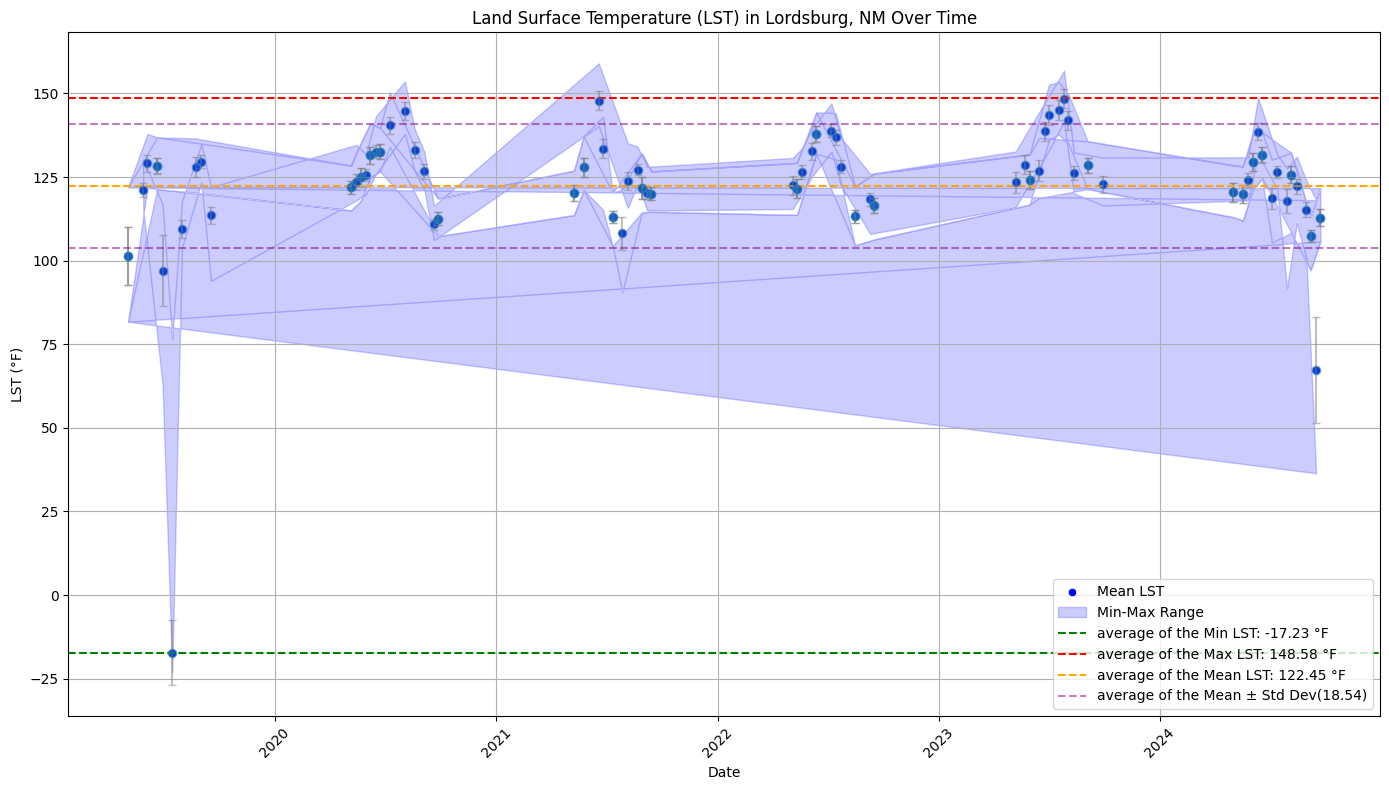

In [100]:
# Create the DataFrame
data = {
    'Date': [ee.Date(date).format("YYYY-MM-dd").getInfo() for date in dates],
    'Mean_LST': means,
    'Min_LST': mins,
    'Max_LST': maxs,
    'StdDev_LST': std_devs
}
df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])

# Overall collection statistics
overall_min = -17.23
overall_max = 148.58  
overall_std_dev = 18.54
overall_mean =  122.45 

# Set up the scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Date', y='Mean_LST', data=df, color='blue', label='Mean LST')

# Add error bars for standard deviation
plt.errorbar(df['Date'], df['Mean_LST'], yerr=df['StdDev_LST'], fmt='o', ecolor='gray', alpha=0.5, capsize=3)

# Add shaded area for Min-Max range
plt.fill_between(df['Date'], df['Min_LST'], df['Max_LST'], color='blue', alpha=0.2, label='Min-Max Range')

# Add overall statistics as horizontal lines
plt.axhline(overall_min, color='green', linestyle='--', label=f'average of the Min LST: {overall_min:.2f} °F')
plt.axhline(overall_max, color='red', linestyle='--', label=f'average of the Max LST: {overall_max:.2f} °F')
plt.axhline(overall_mean, color='orange', linestyle='--', label=f'average of the Mean LST: {overall_mean:.2f} °F')
plt.axhline(overall_mean + overall_std_dev, color='purple', linestyle='--', alpha=0.5, label=f'average of the Mean ± Std Dev({overall_std_dev})')
plt.axhline(overall_mean - overall_std_dev, color='purple', linestyle='--', alpha=0.5)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('LST (°F)')
plt.title('Land Surface Temperature (LST) in Lordsburg, NM Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [98]:
""" # Compute the long-term baseline (mean of all images in the collection)
baseline = processed_collection.mean()

# Function to calculate the anomaly for each image
def calculate_anomaly(image):
    anomaly = image.select('LST_F').subtract(baseline.select('LST_F'))  # Subtract baseline pixel by pixel
    return image.addBands(anomaly.rename('LST_Anomaly'))  # Add anomaly as a new band

# Map the anomaly calculation across the processed collection
anomaly_collection = processed_collection.map(calculate_anomaly)

# Visualization parameters for anomalies
anomaly_vis_params = {
    'min': -20,  # Adjust based on expected range of anomalies
    'max': 20,
    'palette': ['blue', 'white', 'red'],  # Blue for cooler, red for warmer
}

# Add the mean anomaly layer to the map
Map = geemap.Map()
Map.center_object(ee_lordsburg, 12)

# Visualize mean anomaly across the collection
mean_anomaly = anomaly_collection.select('LST_Anomaly').mean()
Map.addLayer(mean_anomaly, anomaly_vis_params, 'Mean Temperature Anomaly')
Map.addLayer(ee_lordsburg, {}, 'lordsburg Boundary')
Map
 """

" # Compute the long-term baseline (mean of all images in the collection)\nbaseline = processed_collection.mean()\n\n# Function to calculate the anomaly for each image\ndef calculate_anomaly(image):\n    anomaly = image.select('LST_F').subtract(baseline.select('LST_F'))  # Subtract baseline pixel by pixel\n    return image.addBands(anomaly.rename('LST_Anomaly'))  # Add anomaly as a new band\n\n# Map the anomaly calculation across the processed collection\nanomaly_collection = processed_collection.map(calculate_anomaly)\n\n# Visualization parameters for anomalies\nanomaly_vis_params = {\n    'min': -20,  # Adjust based on expected range of anomalies\n    'max': 20,\n    'palette': ['blue', 'white', 'red'],  # Blue for cooler, red for warmer\n}\n\n# Add the mean anomaly layer to the map\nMap = geemap.Map()\nMap.center_object(ee_lordsburg, 12)\n\n# Visualize mean anomaly across the collection\nmean_anomaly = anomaly_collection.select('LST_Anomaly').mean()\nMap.addLayer(mean_anomaly, anoma

In [99]:
""" # Set up export parameters
export_task = ee.batch.Export.image.toDrive(
    image=mean_anomaly.select('LST_Anomaly'),  # Select the LST band
    description='lordsburg_LST_Anomaly',
    folder='lst',  # Optional: specify a folder in Google Drive
    fileNamePrefix='lordsburg_LST_Anomaly',
    region=ee_lordsburg,
    scale=30,
    crs='EPSG:4326',  # 'EPSG:32612',  # Use UTM Zone 12N to match the lordsburg vectors
    maxPixels=1e13
)

# Start the export task
export_task.start()
print("Exporting LST_Anomaly to Google Drive...") """

' # Set up export parameters\nexport_task = ee.batch.Export.image.toDrive(\n    image=mean_anomaly.select(\'LST_Anomaly\'),  # Select the LST band\n    description=\'lordsburg_LST_Anomaly\',\n    folder=\'lst\',  # Optional: specify a folder in Google Drive\n    fileNamePrefix=\'lordsburg_LST_Anomaly\',\n    region=ee_lordsburg,\n    scale=30,\n    crs=\'EPSG:4326\',  # \'EPSG:32612\',  # Use UTM Zone 12N to match the lordsburg vectors\n    maxPixels=1e13\n)\n\n# Start the export task\nexport_task.start()\nprint("Exporting LST_Anomaly to Google Drive...") '

Per-image LST statistics:
Date: 2019-05-29, Mean LST: 121.14904828681419, Min LST: 115.71497704400007, Max LST: 130.228573568, StdDev LST: 2.2043845460270064
Date: 2019-06-30, Mean LST: 97.01424017095619, Min LST: 62.82863718800005, Max LST: 116.8039582160001, StdDev LST: 10.689903739594639
Date: 2019-07-16, Mean LST: -17.19985783742735, Min LST: -23.17011321999994, Max LST: 76.57933164800002, StdDev LST: 9.677426885054436
Date: 2019-08-01, Mean LST: 109.44042308384597, Min LST: 103.87153774400011, Max LST: 117.769890668, StdDev LST: 2.6050749248283
Date: 2019-09-02, Mean LST: 129.6222322295111, Min LST: 123.48550371200001, Max LST: 134.74446159200005, StdDev LST: 1.8688278955253375
Date: 2019-09-18, Mean LST: 113.54754671962306, Min LST: 93.95996334800006, Max LST: 121.96585202000003, StdDev LST: 2.4547768031053074
Date: 2020-05-15, Mean LST: 123.39169528452673, Min LST: 118.01598810800006, Max LST: 134.63371774400002, StdDev LST: 2.387128948659508
Date: 2020-05-31, Mean LST: 125.46019124750102, Min LST: 119.92324326800008, Max LST: 131.71746308000007, StdDev LST: 1.800342111289145
Date: 2020-06-16, Mean LST: 132.62103898525606, Min LST: 125.8234293920001, Max LST: 143.13023185999998, StdDev LST: 1.8192320296261058
Date: 2020-08-03, Mean LST: 144.77380328156434, Min LST: 137.88220395200008, Max LST: 153.60167793200003, StdDev LST: 2.676078157734717
Date: 2020-08-19, Mean LST: 133.01167844900334, Min LST: 126.80781915200004, Max LST: 139.432617824, StdDev LST: 2.329377518464199
Date: 2020-09-04, Mean LST: 126.74176002228347, Min LST: 121.04913905599999, Max LST: 132.63417604400001, StdDev LST: 2.2018341471580567
Date: 2020-09-20, Mean LST: 110.87971261768459, Min LST: 106.10487201199999, Max LST: 116.39789744000002, StdDev LST: 1.6908653782242877
Date: 2021-06-19, Mean LST: 147.8327341415625, Min LST: 140.21397719600003, Max LST: 158.96660212400002, StdDev LST: 2.8187353667156314
Date: 2021-08-06, Mean LST: 123.67743498091518, Min LST: 115.70267217199996, Max LST: 135.07669313600007, StdDev LST: 2.7134977520546557
Date: 2021-08-22, Mean LST: 127.24071664481355, Min LST: 122.901022292, Max LST: 134.10460824800003, StdDev LST: 1.656893234405374
Date: 2021-09-07, Mean LST: 120.3024199202657, Min LST: 114.96437985199998, Max LST: 128.032153916, StdDev LST: 1.9296967843059316
Date: 2022-05-05, Mean LST: 122.4915407449008, Min LST: 115.42581255200007, Max LST: 130.69615870400003, StdDev LST: 2.8867959253889355
Date: 2022-05-21, Mean LST: 126.55800939245222, Min LST: 119.990920064, Max LST: 133.692395036, StdDev LST: 2.1528334330804704
Date: 2022-06-06, Mean LST: 132.64585729958608, Min LST: 125.15896630400007, Max LST: 139.4449226960001, StdDev LST: 2.4707859294343955
Date: 2022-07-08, Mean LST: 138.90054111482007, Min LST: 132.53573706800006, Max LST: 147.0370287200001, StdDev LST: 1.9695855144500283
Date: 2022-07-24, Mean LST: 128.13433091354426, Min LST: 122.28577869200005, Max LST: 136.657869188, StdDev LST: 1.8846133529625684
Date: 2022-09-10, Mean LST: 118.3033699150087, Min LST: 107.9690601200001, Max LST: 125.92802080400008, StdDev LST: 2.0153330685749586
Date: 2023-05-08, Mean LST: 123.36788587417445, Min LST: 115.88724525199996, Max LST: 132.64032848000005, StdDev LST: 3.025415006840398
Date: 2023-05-24, Mean LST: 128.6733474819197, Min LST: 121.0368341840001, Max LST: 137.51921022800002, StdDev LST: 2.8672464213645754
Date: 2023-06-25, Mean LST: 138.63252972725797, Min LST: 130.68385383200007, Max LST: 147.196992056, StdDev LST: 2.962049370949295
Date: 2023-07-27, Mean LST: 148.4324315459616, Min LST: 141.53675093600003, Max LST: 156.83785926800002, StdDev LST: 2.7588944841044483
Date: 2023-08-12, Mean LST: 126.11411175153512, Min LST: 120.12012121999997, Max LST: 132.30809693600003, StdDev LST: 2.1210391395802586
Date: 2023-09-29, Mean LST: 122.82201679223107, Min LST: 116.49633641599996, Max LST: 130.806902552, StdDev LST: 2.5387927000043424
Date: 2024-05-26, Mean LST: 124.14172520785294, Min LST: 117.97907349199998, Max LST: 130.89303665600005, StdDev LST: 2.126707944061468
Date: 2024-06-11, Mean LST: 138.58087167315742, Min LST: 131.86512154399998, Max LST: 148.69203400400002, StdDev LST: 2.595693323386815
Date: 2024-07-13, Mean LST: 126.47091434019389, Min LST: 121.33215111200003, Max LST: 131.63132897600002, StdDev LST: 1.8892611974141729
Date: 2024-07-29, Mean LST: 117.73174536083113, Min LST: 91.84352536400004, Max LST: 127.46612980400002, StdDev LST: 3.5459929507221286
Date: 2024-08-14, Mean LST: 122.27911803789162, Min LST: 111.10680248000001, Max LST: 131.10221948000003, StdDev LST: 2.2595560098990766
Date: 2024-08-30, Mean LST: 115.26767513705491, Min LST: 100.59844179200006, Max LST: 123.87310718000005, StdDev LST: 2.3695253811972594
Date: 2024-09-15, Mean LST: 67.23358043109617, Min LST: 36.41007700399998, Max LST: 118.08366490399997, StdDev LST: 15.886293444090962
Date: 2019-05-04, Mean LST: 101.32244297873206, Min LST: 81.71661570799998, Max LST: 121.93508984000009, StdDev LST: 8.648264511048364
Date: 2019-06-21, Mean LST: 128.36907838388817, Min LST: 121.36291329199996, Max LST: 136.86089957600007, StdDev LST: 2.324617021315349
Date: 2019-08-24, Mean LST: 127.98188255778534, Min LST: 120.32930404400005, Max LST: 136.52866803200004, StdDev LST: 3.0270023975113762
Date: 2020-05-06, Mean LST: 121.92082768260208, Min LST: 115.02590421200004, Max LST: 128.42590981999996, StdDev LST: 1.8942882002990975
Date: 2020-05-22, Mean LST: 124.91167879753407, Min LST: 117.84371990000005, Max LST: 135.16897967599996, StdDev LST: 2.6833863999020378
Date: 2020-06-07, Mean LST: 131.43270849723476, Min LST: 124.832887196, Max LST: 141.0568609280001, StdDev LST: 2.516296880823773
Date: 2020-06-23, Mean LST: 132.5377345933286, Min LST: 126.65400825199997, Max LST: 139.660257956, StdDev LST: 2.2919953407384015
Date: 2020-09-27, Mean LST: 112.5567772941925, Min LST: 107.29229215999997, Max LST: 118.49587811600009, StdDev LST: 1.8782423125925194
Date: 2021-05-09, Mean LST: 120.28336220996805, Min LST: 113.61699636799999, Max LST: 126.91241056400003, StdDev LST: 2.4250324175364937
Date: 2021-05-25, Mean LST: 127.88632963702484, Min LST: 121.11066341600007, Max LST: 137.10699701600004, StdDev LST: 2.7930913944230484
Date: 2021-07-12, Mean LST: 112.98559145319288, Min LST: 104.38218993199996, Max LST: 120.21240776000006, StdDev LST: 1.7974616748290528
Date: 2021-08-29, Mean LST: 121.63365184432644, Min LST: 114.410660612, Max LST: 132.14813360000002, StdDev LST: 3.2362430484620455
Date: 2021-09-14, Mean LST: 120.03295911388506, Min LST: 114.60138612800004, Max LST: 126.64170338000008, StdDev LST: 1.9791316126961587
Date: 2022-05-12, Mean LST: 121.50788055116409, Min LST: 113.66006342000001, Max LST: 129.20726919200007, StdDev LST: 2.8128445975381418
Date: 2022-06-13, Mean LST: 137.95839511058844, Min LST: 131.96971295599997, Max LST: 144.30534713600005, StdDev LST: 2.3715240644508517
Date: 2022-08-16, Mean LST: 113.31839949937824, Min LST: 104.56676301200007, Max LST: 122.16888240800006, StdDev LST: 1.9359660566524326
Date: 2022-09-17, Mean LST: 116.4777802284861, Min LST: 106.332512144, Max LST: 126.05106952400001, StdDev LST: 2.2866667570303534
Date: 2023-05-31, Mean LST: 123.97089126729897, Min LST: 116.73628141999998, Max LST: 131.71131064400004, StdDev LST: 2.6798720988070075
Date: 2023-06-16, Mean LST: 126.9090437350804, Min LST: 118.72967068400006, Max LST: 136.66402162400007, StdDev LST: 3.13517923329089
Date: 2023-09-04, Mean LST: 128.4814426695968, Min LST: 121.37521816400006, Max LST: 135.68578430000008, StdDev LST: 2.164089802149041
Date: 2024-05-01, Mean LST: 120.38503798199308, Min LST: 113.00790520399998, Max LST: 128.4382146920001, StdDev LST: 2.7362040951634
Date: 2024-05-17, Mean LST: 119.78859458298146, Min LST: 112.01121057200005, Max LST: 128.161355072, StdDev LST: 2.6734463623189977
Date: 2024-06-02, Mean LST: 129.36746500301624, Min LST: 120.9568525160001, Max LST: 137.605344332, StdDev LST: 2.685913195895669
Date: 2024-06-18, Mean LST: 131.66548853919818, Min LST: 124.65446655200006, Max LST: 138.31287447200003, StdDev LST: 2.3348919485626576
Date: 2024-07-04, Mean LST: 118.6385873495827, Min LST: 105.42810405200008, Max LST: 130.191658952, StdDev LST: 3.159999923724142
Date: 2024-08-05, Mean LST: 125.72254453717895, Min LST: 108.32590140799998, Max LST: 132.228115268, StdDev LST: 2.6295085308809276
Date: 2024-09-06, Mean LST: 107.38005668981566, Min LST: 97.14077276, Max LST: 113.06327712800001, StdDev LST: 1.8503792250177198
Date: 2024-09-22, Mean LST: 112.83642806412306, Min LST: 105.72957341600005, Max LST: 121.65823022, StdDev LST: 2.452967507737272
Date: 2019-05-04, Mean LST: 101.33782821672338, Min LST: 81.73507301600002, Max LST: 121.99661420000005, StdDev LST: 8.648775631415656
Date: 2019-06-05, Mean LST: 129.06053007286667, Min LST: 121.81204111999996, Max LST: 137.85144177200004, StdDev LST: 2.4894761357679926
Date: 2019-06-21, Mean LST: 128.388587104772, Min LST: 121.36291329199996, Max LST: 136.89781419200006, StdDev LST: 2.329174501900112
Date: 2020-05-06, Mean LST: 121.93566763620504, Min LST: 115.04436151999998, Max LST: 128.42590981999996, StdDev LST: 1.8979995281215234
Date: 2020-05-22, Mean LST: 124.93012591162854, Min LST: 117.849872336, Max LST: 135.18128454800006, StdDev LST: 2.6867096611686847
Date: 2020-06-07, Mean LST: 131.44944633252027, Min LST: 124.83903963200005, Max LST: 141.1368425960001, StdDev LST: 2.5217381825528795
Date: 2020-06-23, Mean LST: 132.5504634019253, Min LST: 126.64170338000008, Max LST: 139.666410392, StdDev LST: 2.295942672088973
Date: 2020-07-09, Mean LST: 140.40695856526, Min LST: 134.0492363240001, Max LST: 150.4208685200001, StdDev LST: 2.5885205697841176
Date: 2020-09-27, Mean LST: 112.57470297788838, Min LST: 107.31074946800011, Max LST: 118.57585978400009, StdDev LST: 1.881900801999341
Date: 2021-05-09, Mean LST: 120.29401819370453, Min LST: 113.62930124000009, Max LST: 126.91241056400003, StdDev LST: 2.427899176598572
Date: 2021-05-25, Mean LST: 127.90441788813496, Min LST: 121.13527316000004, Max LST: 137.15621650399999, StdDev LST: 2.7958896253527783
Date: 2021-06-26, Mean LST: 133.5191274730923, Min LST: 115.25969678000001, Max LST: 143.001030704, StdDev LST: 2.8711885817555673
Date: 2021-07-12, Mean LST: 113.00120089765787, Min LST: 104.43756185599999, Max LST: 120.29238942800008, StdDev LST: 1.7984408466846107
Date: 2021-07-28, Mean LST: 108.12742806630528, Min LST: 90.49614187999995, Max LST: 121.36906572800001, StdDev LST: 4.81006979527175
Date: 2021-08-29, Mean LST: 121.64819855239408, Min LST: 114.42911792000004, Max LST: 132.14813360000002, StdDev LST: 3.235171709218408
Date: 2021-09-14, Mean LST: 120.04954606198655, Min LST: 114.595233692, Max LST: 126.68477043200001, StdDev LST: 1.9814229185471766
Date: 2022-05-12, Mean LST: 121.52555658706913, Min LST: 113.66621585599997, Max LST: 129.250336244, StdDev LST: 2.8159827752287816
Date: 2022-06-13, Mean LST: 137.97701905624805, Min LST: 131.96356052000004, Max LST: 144.348414188, StdDev LST: 2.375235824812034
Date: 2022-07-15, Mean LST: 136.82722437653186, Min LST: 130.30240279999998, Max LST: 144.16384110799999, StdDev LST: 2.171313223771935
Date: 2022-08-16, Mean LST: 113.29944378759099, Min LST: 104.52369596000004, Max LST: 122.14427266400007, StdDev LST: 1.9362078505020357
Date: 2022-09-17, Mean LST: 116.48766732464841, Min LST: 106.332512144, Max LST: 126.06337439600011, StdDev LST: 2.2887441173784193
Date: 2023-05-31, Mean LST: 123.9911757997466, Min LST: 116.75473872800002, Max LST: 131.735920388, StdDev LST: 2.6835608924270944
Date: 2023-07-02, Mean LST: 143.53610569284862, Min LST: 136.03647315200004, Max LST: 152.67266009600002, StdDev LST: 3.08129778555742
Date: 2023-07-18, Mean LST: 145.00760904356065, Min LST: 137.67917356400005, Max LST: 153.39249510799996, StdDev LST: 2.8941816309483137
Date: 2023-08-03, Mean LST: 141.91629203525963, Min LST: 134.91672980000004, Max LST: 149.81792979200003, StdDev LST: 2.7239987354348534
Date: 2023-09-04, Mean LST: 128.49852925170617, Min LST: 121.38752303600005, Max LST: 135.7165464800001, StdDev LST: 2.1669927256425217
Date: 2024-05-01, Mean LST: 120.40451944595547, Min LST: 112.9956003320001, Max LST: 128.56741584800005, StdDev LST: 2.7387867508707666
Date: 2024-05-17, Mean LST: 119.80831560601541, Min LST: 112.03582031600004, Max LST: 128.17365994400006, StdDev LST: 2.677234637839271
Date: 2024-06-02, Mean LST: 129.3900856365768, Min LST: 120.98761469600002, Max LST: 137.7530027960001, StdDev LST: 2.6909632385827376
Date: 2024-06-18, Mean LST: 131.68541165218176, Min LST: 124.63600924400002, Max LST: 138.33133178000008, StdDev LST: 2.338227962627623
Date: 2024-08-05, Mean LST: 125.7371698055489, Min LST: 108.32590140799998, Max LST: 132.2773347560001, StdDev LST: 2.627718144310807
Date: 2024-09-06, Mean LST: 107.39799513304408, Min LST: 97.13462032400007, Max LST: 113.11249661599997, StdDev LST: 1.853265360914863
Date: 2024-09-22, Mean LST: 112.85366615995858, Min LST: 105.72342098000011, Max LST: 121.68899240000003, StdDev LST: 2.456887990634337